In [ ]:
!pip install transformers datasets evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 491.2/491.2 kB 15.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 4.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 183.9/183.9 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.5/143.5 kB 4.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.8/194.8 kB 14.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.3.2
    Uninstalling fsspec-2025.3.2:
      Successfully uninstalled fsspec-2025.3.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.6.0+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

In [ ]:
import re
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import TextVectorization
from sklearn.model_selection import train_test_split
from datasets import load_dataset

# === 1. Load and Prepare SQuAD Dataset ===
squad_dataset = load_dataset("squad")
df = squad_dataset['train'].to_pandas()
df = df[['context', 'question', 'answers']]

# Extract answer text and start position
df['answer_text'] = df['answers'].apply(lambda x: x['text'][0] if x['text'] else '')
df['answer_start'] = df['answers'].apply(lambda x: x['answer_start'][0] if x['answer_start'] else -1)

# Filter out rows with no valid answers
df = df[(df['answer_text'] != '') & (df['answer_start'] != -1)]

# Add a column for the end position of the answer
df['answer_end'] = df.apply(lambda x: x['answer_start'] + len(x['answer_text']), axis=1)

# Add a column for context length
df['context_length'] = df['context'].apply(len)

# Sort by context length (ascending) and take the shortest 10,000
df = df.sort_values(by='context_length').head(10000).copy()

# Keep only the needed columns
df = df[['context', 'question', 'answer_text', 'answer_start', 'answer_end']]

# === 2. Prepare Text Data ===
sequence_length = 125
vocab_size = 15000

# Combine context and question
df['combined'] = df.apply(lambda x: x['question'] + ' [SEP] ' + x['context'], axis=1)

# Create TextVectorization layer
vectorizer = TextVectorization(
    max_tokens=vocab_size,
    output_mode="int",
    output_sequence_length=sequence_length,
    standardize=None
)
vectorizer.adapt(df['combined'].values)

# Tokenize inputs
tokenized_inputs = vectorizer(df['combined'].values).numpy()

# === 3. Map Char to Token Indexes ===
def char_to_token_index(combined_text, answer_start_char, answer_end_char, vectorizer):
    tokens = vectorizer([combined_text]).numpy()[0]
    vocab = vectorizer.get_vocabulary()
    inv_vocab = {i: w for i, w in enumerate(vocab)}

    token_offsets = []
    current_char = 0
    for token_id in tokens:
        token = inv_vocab.get(token_id, '')
        if not token or token in ['[PAD]', '[UNK]']:
            token_offsets.append((None, None))
            continue
        token_start = combined_text.find(token, current_char)
        token_end = token_start + len(token)
        token_offsets.append((token_start, token_end))
        current_char = token_end

    start_token = end_token = None
    for i, (start, end) in enumerate(token_offsets):
        if start is None:
            continue
        if start_token is None and start >= answer_start_char:
            start_token = i
        if end_token is None and end >= answer_end_char:
            end_token = i
            break

    if start_token is None or end_token is None:
        return 0, 0

    return start_token, end_token

start_token_positions = []
end_token_positions = []
for i in range(len(df)):
    row = df.iloc[i]
    q = row['question']
    c = row['context']
    a_start = row['answer_start']
    a_end = row['answer_end']
    combined = q + ' [SEP] ' + c
    adjusted_start = len(q + ' [SEP] ') + a_start
    adjusted_end = len(q + ' [SEP] ') + a_end
    start_tok, end_tok = char_to_token_index(combined, adjusted_start, adjusted_end, vectorizer)
    start_token_positions.append(start_tok)
    end_token_positions.append(end_tok)


df['start_token'] = start_token_positions
df['end_token'] = end_token_positions

# === 4. Prepare Train/Val Split ===
start_positions = np.array(start_token_positions)
end_positions = np.array(end_token_positions)

train_input, val_input, train_start, val_start, train_end, val_end = train_test_split(
    tokenized_inputs, start_positions, end_positions, test_size=0.15, random_state=42
)

train_start = train_start.flatten()
train_end = train_end.flatten()
val_start = val_start.flatten()
val_end = val_end.flatten()

print("Data prepared:")
print("Train shape:", train_input.shape)
print("Example start/end token:", train_start[0], train_end[0])



/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md:   0%|          | 0.00/7.62k [00:00<?, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/14.5M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/1.82M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/87599 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/10570 [00:00<?, ? examples/s]

<ipython-input-2-41d086467805>:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['answer_text'] = df['answers'].apply(lambda x: x['text'][0] if x['text'] else '')


Data prepared:
Train shape: (8500, 125)
Example start/end token: 31 31


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# 1. Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")

# 2. Fit on text
tokenizer.fit_on_texts(df["combined"])

# 3. Convert text to sequences
sequences = tokenizer.texts_to_sequences(df["combined"])

# 4. Get the maximum sequence length
max_len = max(len(seq) for seq in sequences)

print(f"Longest sequence length: {max_len}")


Longest sequence length: 124


In [ ]:
from tensorflow.keras.preprocessing.sequence import pad_sequences

padded_sequences = pad_sequences(sequences, maxlen=max_len, padding='post', truncating='post')

print("\n Sample padded sequence:\n", padded_sequences[0])
print("Padded shape:", padded_sequences.shape)


 Sample padded sequence:
 [  67    9    2  419  133    3 1340    5 7109  157    8    2  419  133
    3 1340    5 7109    7  133   13   49    3    2 2097   44 7788    1
    5 1340 2968    9   34  157    4  419   32    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0    0    0
    0    0    0    0    0    0    0    0    0    0    0    0]
Padded shape: (10000, 124)


In [ ]:

df.to_csv('squad_processed.csv', index=False)
df

,context,question,answer_text,answer_start,answer_end,combined,start_token,end_token
12947,The Oklahoma School of Science and Mathematics...,Where is The Oklahoma School of Science and Ma...,Oklahoma City,137,150,Where is The Oklahoma School of Science and Ma...,35,36
12245,"Meanwhile, the USSR continued briefly trying t...",Which year did the USSR cancel the N1 rocket p...,1976,97,101,Which year did the USSR cancel the N1 rocket p...,32,32
12696,"In the past, the Malays used to call the Portu...",What term did the Malays use for the Portugues...,Nasrani,75,82,What term did the Malays use for the Portugues...,26,26
12697,"In the past, the Malays used to call the Portu...",What does the term refer to now?,the modern Kristang creoles of Malaysia,111,150,What does the term refer to now? [SEP] In the...,0,0
24530,New Delhi has been selected as one of the hund...,How many Indian cities have been selected to b...,hundred,42,49,How many Indian cities have been selected to b...,24,24
...,...,...,...,...,...,...,...,...
84442,In what will be the case is Town of Greece v. ...,Who did the Supreme Court rule in favor of?,Town of Greece,329,343,Who did the Supreme Court rule in favor of? [S...,69,71
27485,Stout and porter are dark beers made using roa...,In what country was Porter beer popular in 1721?,London,326,332,In what country was Porter beer popular in 172...,66,66
27481,Stout and porter are dark beers made using roa...,In what year was the name Porter first used fo...,1721,246,250,In what year was the name Porter first used fo...,56,56
27482,Stout and porter are dark beers made using roa...,In what year was the name stout first used to ...,1677,431,435,In what year was the name stout first used to ...,92,92


In [ ]:
start_positions


array([35, 32, 26, ..., 56, 92, 49])

In [ ]:
end_positions

array([36, 32, 26, ..., 56, 92, 50])

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers, Model

# === Model Hyperparameters ===
# sequence_length = 300
vocab_size = 15000
embed_dim = 256
num_heads = 8
dense_dim = 2048

# === Input Layer ===
inputs = layers.Input(shape=(sequence_length,), name="input_tokens")

# === Embedding + Positional Encoding ===
embedding_layer = layers.Embedding(input_dim=vocab_size, output_dim=embed_dim)(inputs)

class PositionalEncoding(layers.Layer):
    def __init__(self, sequence_length, embed_dim):
        super().__init__()
        self.position_embedding = layers.Embedding(input_dim=sequence_length, output_dim=embed_dim)

    def call(self, inputs):
        position = tf.range(start=0, limit=sequence_length, delta=1)
        position = self.position_embedding(position)
        return inputs + position

x = PositionalEncoding(sequence_length, embed_dim)(embedding_layer)

# === Transformer Encoder ===
class TransformerEncoder(layers.Layer):
    def __init__(self, embed_dim, num_heads, dense_dim):
        super().__init__()
        self.attn = layers.MultiHeadAttention(num_heads=num_heads, key_dim=embed_dim)
        self.ffn = tf.keras.Sequential([
            layers.Dense(dense_dim, activation='relu'),
            layers.Dense(embed_dim)
        ])
        self.layernorm1 = layers.LayerNormalization()
        self.layernorm2 = layers.LayerNormalization()
        self.dropout1 = layers.Dropout(0.1)
        self.dropout2 = layers.Dropout(0.1)

    def call(self, inputs):
        attn_output = self.attn(inputs, inputs)
        attn_output = self.dropout1(attn_output)
        out1 = self.layernorm1(inputs + attn_output)

        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output)
        return self.layernorm2(out1 + ffn_output)

# Add Transformer block(s)
x = TransformerEncoder(embed_dim, num_heads, dense_dim)(x)

# === Predict Start and End Token Positions (token-level) ===
start_logits = layers.Dense(1, name="start_logit")(x)  # (batch_size, seq_len, 1)
end_logits = layers.Dense(1, name="end_logit")(x)      # (batch_size, seq_len, 1)

start_output = layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(start_logits)
end_output = layers.Lambda(lambda x: tf.squeeze(x, axis=-1))(end_logits)


start_output = layers.Activation("softmax", name="start_output")(start_output)
end_output = layers.Activation("softmax", name="end_output")(end_output)

# === Model Definition ===
model = Model(inputs=inputs, outputs=[start_output, end_output])

# === Compile ===
model.compile(
    optimizer="adam",
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy", "accuracy"]  # One for each output
)


# === Train ===
history = model.fit(
    train_input, [train_start, train_end],
    validation_data=(val_input, [val_start, val_end]),
    epochs=30,
    batch_size=64
)

# === Evaluate ===
results = model.evaluate(val_input, [val_start, val_end])
print("Validation Loss & Accuracy:", results)


Epoch 1/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 136ms/step - end_output_accuracy: 0.0447 - end_output_loss: 3.9712 - loss: 7.9758 - start_output_accuracy: 0.0423 - start_output_loss: 4.0046 - val_end_output_accuracy: 0.0680 - val_end_output_loss: 3.6337 - val_loss: 7.2884 - val_start_output_accuracy: 0.0633 - val_start_output_loss: 3.6678
Epoch 2/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 27s 77ms/step - end_output_accuracy: 0.1417 - end_output_loss: 3.1114 - loss: 6.4107 - start_output_accuracy: 0.1184 - start_output_loss: 3.2993 - val_end_output_accuracy: 0.0787 - val_end_output_loss: 3.8164 - val_loss: 7.5641 - val_start_output_accuracy: 0.0740 - val_start_output_loss: 3.7671
Epoch 3/30
133/133 ━━━━━━━━━━━━━━━━━━━━ 21s 79ms/step - end_output_accuracy: 0.1700 - end_output_loss: 2.8584 - loss: 5.9083 - start_output_accuracy: 0.1462 - start_output_loss: 3.0499 - val_end_output_accuracy: 0.0860 - val_end_output_loss: 4.3010 - val_loss: 8.2490 - val_start_output_accuracy: 0.0713 - val_start_output_loss

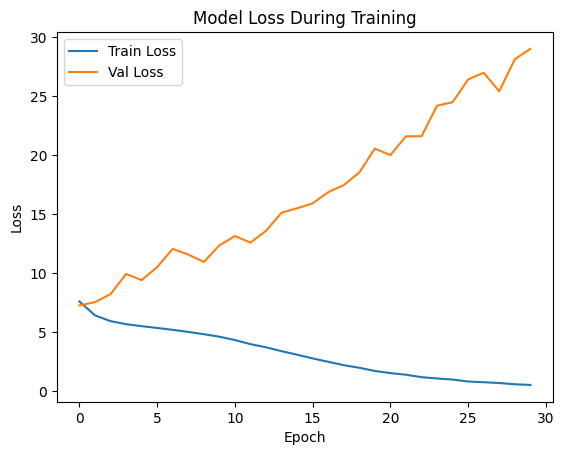

In [ ]:
import matplotlib.pyplot as plt

# === 6. Plot Training Loss ===
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Model Loss During Training')
plt.legend()
plt.show()



In [ ]:
import numpy as np
import tensorflow as tf

def get_answer(model, question, context, vectorizer):
    sep_token = '[SEP]'
    combined = question + ' ' + sep_token + ' ' + context

    # Vectorize combined input
    input_tokens = vectorizer([combined])
    input_tokens_np = input_tokens.numpy()

    # Predict start and end
    pred_start, pred_end = model.predict(input_tokens, verbose=0)
    pred_start = np.argmax(pred_start[0])
    pred_end = np.argmax(pred_end[0])
    if pred_end < pred_start:
        pred_end = pred_start

    # === New logic: tokenize raw combined text ===
    combined_tokens = combined.split()
    context_tokens = context.split()

    # Find where context starts in the combined token list
    question_len = len(question.split())
    sep_offset = 1  # [SEP] is one token
    context_start_index = question_len + sep_offset  # skip question and [SEP]

    # Adjust prediction span to be within context
    context_pred_start = pred_start - context_start_index
    context_pred_end = pred_end - context_start_index

    # Clamp bounds
    context_pred_start = max(0, context_pred_start)
    context_pred_end = min(len(context_tokens) - 1, context_pred_end)

    # Extract tokens from raw context
    predicted_tokens = context_tokens[context_pred_start:context_pred_end + 1]
    answer = ' '.join(predicted_tokens)

    #POST PROCESSING

    # Remove trailing punctuation if present
    if answer and answer[-1] in {',', '.', ';'}:
        answer = answer[:-1].strip()

    if answer.endswith("'s"):
      no_possessive = answer[:-2]
      if no_possessive in context:
          answer = no_possessive

    return answer.strip() if answer else "[No Answer Found]"


In [ ]:
i = 2222
row = df.iloc[i]
print("Q:", row['question'])
print("Context:", row['context'])
print("True:", row['answer_text'])
print("Predicted:", get_answer(model, row['question'], row['context'], vectorizer))


Q: Whic organization is responsible for filtering movie content in India?
Context: In India, it was reported that the Indian Central Board of Film Certification (CBFC) censored kissing scenes featuring Monica Bellucci, Daniel Craig, and Léa Seydoux. They also muted all profanity. This prompted criticism of the board online, especially on Twitter.
True: Indian Central Board of Film Certification
Predicted: Indian Central Board of Film Certification (CBFC) censored kissing scenes


In [ ]:
def test_model_on_samples(model, df, vectorizer, num_samples=20):
    import random
    samples = df.sample(n=num_samples, random_state=42).reset_index(drop=True)

    for i in range(num_samples):
        question = samples.loc[i, 'question']
        context = samples.loc[i, 'context']
        true_answer = samples.loc[i, 'answer_text']

        predicted_answer = get_answer(model, question, context, vectorizer)

        print(f"\nQ: {question}")
        print(f"\nC: {context}")
        print(f"True: {true_answer}")
        print(f"Predicted: {predicted_answer}")
        print("-" * 50)



In [ ]:
test_model_on_samples(model, df , vectorizer)


Q: When did the UN General Assembly approve the Marshall Islands joining the UN?

C: The Marshall Islands was admitted to the United Nations based on the Security Council's recommendation on August 9, 1991, in Resolution 704 and the General Assembly's approval on September 17, 1991, in Resolution 46/3. In international politics within the United Nations, the Marshall Islands has often voted consistently with the United States with respect to General Assembly resolutions.
True: September 17, 1991
Predicted: on
--------------------------------------------------

Q: What was the diagnosis of Chopin's health condition at this time?

C: Chopin made his last public appearance on a concert platform at London's Guildhall on 16 November 1848, when, in a final patriotic gesture, he played for the benefit of Polish refugees. By this time he was very seriously ill, weighing under 99 pounds (i.e. less than 45 kg), and his doctors were aware that his sickness was at a terminal stage.
True: terminal

In [ ]:
import numpy as np
from sklearn.metrics import precision_score, recall_score, f1_score

def evaluate_predictions(model, val_input, val_start, val_end):
    # 1. Get predictions from the model
    pred_start_probs, pred_end_probs = model.predict(val_input)

    # 2. Get predicted start and end token indices
    pred_start = np.argmax(pred_start_probs, axis=1)
    pred_end = np.argmax(pred_end_probs, axis=1)

    # 3. True values
    true_start = val_start
    true_end = val_end

    # 4. Token-level accuracy
    start_accuracy = np.mean(pred_start == true_start)
    end_accuracy = np.mean(pred_end == true_end)

    # 5. Exact Match (both start and end are correct)
    exact_matches = np.sum((pred_start == true_start) & (pred_end == true_end))
    exact_match_accuracy = exact_matches / len(true_start)

    # 6. F1 Score Calculation (based on overlap of span)
    f1_scores = []
    for ps, pe, ts, te in zip(pred_start, pred_end, true_start, true_end):
        # Skip bad spans
        if ps > pe or ts > te:
            f1_scores.append(0.0)
            continue

        # Convert to sets of token positions
        pred_span = set(range(ps, pe + 1))
        true_span = set(range(ts, te + 1))

        # Precision, Recall, F1
        overlap = len(pred_span & true_span)
        if overlap == 0:
            f1_scores.append(0.0)
            continue

        precision = overlap / len(pred_span)
        recall = overlap / len(true_span)
        f1 = 2 * (precision * recall) / (precision + recall)
        f1_scores.append(f1)

    mean_f1 = np.mean(f1_scores)

    # 7. Print results
    print(" Evaluation Results:")
    print(f"🔹 Start Token Accuracy: {start_accuracy:.2%}")
    print(f"🔹 End Token Accuracy:   {end_accuracy:.2%}")
    print(f"✅ Exact Match Accuracy: {exact_match_accuracy:.2%}")
    print(f"🏅 Average F1 Score:     {mean_f1:.2%}")

    return {
        "start_accuracy": start_accuracy,
        "end_accuracy": end_accuracy,
        "exact_match_accuracy": exact_match_accuracy,
        "f1_score": mean_f1
    }


In [ ]:
results = evaluate_predictions(model, val_input, val_start, val_end)


47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
📊 Evaluation Results:
🔹 Start Token Accuracy: 5.60%
🔹 End Token Accuracy:   6.80%
✅ Exact Match Accuracy: 2.87%
🏅 Average F1 Score:     6.06%
